In [1]:
!pip install sunriset

  Using cached sunriset-1.0-py3-none-any.whl (9.6 kB)
You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import datacube
from datacube.utils import geometry

import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np

# import sunriset ##(will need to `pip install sunriset` on first loading)
from otps import TimePoint
from otps import predict_tide
import pytz
import math
import datetime
from datetime import timedelta
from math import ceil



import sys
sys.path.append("../Scripts")
from dea_plotting import map_shapefile
from dea_dask import create_local_dask_cluster

# solar modelling modules
# import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
dc = datacube.Datacube(app="intertidal_exposure")
create_local_dask_cluster()

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Client Scheduler: tcp://127.0.0.1:44287 Dashboard: /user/cp/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


In [3]:
## Set variables 

# Read in the polygon vector file
%cd '/home/jovyan/dev/dea-notebooks/Claire/'
vector_file = "ITEMv2_tidalmodel.shp"
attribute_col = "ID"
gdf_master = gpd.read_file(vector_file)

# ## Index by date. This may break when time_start or time_end do not appear in the filtered dataset
## Ideally: 18.61 year window (19 years), the global average astronomically forced lunar nodal cycle (e.g. Haigh et al., 2011)
## NOTE: tidal and exposure modelling are set from the `time_start` and `time_end` parameters
time_start = '2019-12-01 00:00:00'
time_end = '2020-12-01 00:00:00'

## Set the frequency to run the tidal modelling
modelled_freq='10min'

# ## Set the filter to apply for the exposure modelling
# time_filter = 'Oct'

query = {
    'product': ['nidem'],
    "dask_chunks": {"time": 1, "x": 1000, "y": 1000}
        }

/home/jovyan/dev/dea-notebooks/Claire


In [4]:
#### TEST CELL!
### Incorporate solar exposure (sunrise/set) and rebuild the datetime filter to generate 
### all required values simultaneously

# ##### Build a list of DataArrays to concat



def exp_model(time_start, time_end, time_filter, modelled_freq, tidepost_lat, tidepost_lon):#, round_stats):
    
    '''
    For each modelled timestep in modelledtides,
    mask NIDEM for the associated tideheight.
    Save the lists of timesteps and masked arrays
    and concatenate to join all arrays on the new
    dimension 'datetime'
    
    Time filtering (`time_filter`) options for exposure mapping routine are:
    all_time,
    day,
    night,
    wet,
    dry,
    summer,
    autumn,
    winter,
    spring,
    Jan,
    Feb,
    Mar,
    Apr,
    May,
    Jun,
    Jul,
    Aug,
    Sep,
    Oct,
    Nov,
    Dec
    
    Use one of the following strings to match your tidepost to set the appropriate `timezone`
    UTC       =  pytz.UTC ## Coordinated Universal Time
    UTC + 8   = 'Australia/West'

    UTC + 9.5 = 'Australia/North'
                'Australia/South'

    UTC + 10  = 'Australia/Queensland'
                'Australia/NSW'
                'Australia/Victoria'
                'Australia/Tasmania'
    '''
    '''------------------------------------'''
    ## Run tidal modelling

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=time_start,
                                  end=time_end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]
        ## Save modelled tides as dataframe
        ## Firstly convert the dates to series
    all_timerange = all_timerange.to_series()
        ## Save dates and tideheights to pd.DataFrame
    modelledtides = pd.DataFrame(data={'timerange': all_timerange,
                       'tideheights': all_tideheights})
    
    return modelledtides

    '''---------------------------------------------------------'''
#     ## Automate timezone selection based on location of tidepost
#     ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
#     if tidepost_lon <= 129.0:
#         timezone = 'Australia/West'
#         local_tz = 8
#     elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
#         timezone = 'Australia/North'
#         local_tz = 9.5
#     elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
#         timezone = 'Australia/South'
#         local_tz = 9.5
#     elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
#         timezone = 'Australia/Queensland'
#         local_tz = 10
#     elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
#         timezone = 'Australia/NSW'
#         local_tz = 10
#     else:
#         print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
#     print('Timezone set to', timezone)
    
#     ## Convert time_start and time_end to datetime objects in local timezone
#     time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
#     time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
#     ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
#     localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

#     ## Convert tz-aware index to local timezone
#     localtides = localtides.tz_convert(timezone)
    
#     ## Reset the index of modelledtides to reflect local times
#     modelledtides['local_timerange'] = localtides
#     modelledtides.set_index('local_timerange', inplace=True)
#     modelledtides.drop('timerange', axis=1, inplace=True)
    
#     '''---------------------------------'''
#     ## Prepare data for use in solar modelling function (sunriset)
#     ## Translate input dates to datetime
#     format = '%Y-%m-%d %H:%M:%S'
#     start = pd.to_datetime(time_start, format=format)
#     end = pd.to_datetime(time_end, format=format)

#     ## Calculate number of days between input dates
#     diff = end-start

#     ## Return difference in years
#     yearsdiff = diff.days/365

#     ## Round up to ensure all modelledtide datetimes are captured in solar model
#     yearsdiff = int(math.ceil(yearsdiff))

#     ## Identify variables for solar model input
#     lat = tidepost_lat ## from tidepost
#     long = tidepost_lon ## from tidepost
# #     local_tz = local_tz  ## hardcoded for 3 Austral regions

#     number_of_years = yearsdiff
#     start_date = datetime.date(start.year, start.month, start.day) ## from query
    
#     ## Create all required time filters
#     ## Create dict to store filtered times
#     filters = {}
    
#     ## Create a filteredtides dataframe for the filters of interest
#     for x in time_filter:
        
#         if x == 'all_time':
#             filteredtides = modelledtides
#             filters[str(x)] = filteredtides

#         elif x == 'daynight':

#             ## Model sunrise and sunset
#             sun_df = sunriset.to_pandas(start_date, lat, long, local_tz, number_of_years)

#             ## Return sunrise/sunset in hh:mm:ss format (str)
#             sun_df['Sunrise hh:mm:ss'] = sun_df['Sunrise'].apply(
#                     lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))
#             sun_df['Sunset hh:mm:ss'] = sun_df['Sunset'].apply(
#                     lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))

#             ## Drop accessory columns
#             sun_df = sun_df[['Sunrise hh:mm:ss','Sunset hh:mm:ss']]

#             ## Set the index as a datetimeindex to match the modelledtide df
#             sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))
            
# #     return sun_df, localtides
#             ## Create dataframe from localtides (lt_df)
#             lt_df=pd.DataFrame(localtides, columns=['localtides'])
#             dates = []
#             times = []
#             for element in localtides:
#                 d = element.date()
#                 dates.append(d)
#                 t = element.time()
#                 times.append(t)
#             lt_df['Date'] = dates
#             lt_df['Time'] = times

#             ## Generate empty dateframe to concatenate day and night attributed timesteps into
#             ltdaynight_df = pd.DataFrame()

#             for index,row in sun_df.iterrows():

#                 ## Translate the time string from sunriset module into datetime.time
#                 hourday = (int(row['Sunrise hh:mm:ss'].split(':')[0]))
#                 minuteday = (int(row['Sunrise hh:mm:ss'].split(':')[1]))
# #                 secday = ceil(float(row['Sunrise hh:mm:ss'].split(':')[-1]))
#                 sunrise = datetime.time(hourday, minuteday)#, secday)

#                 hournight = (int(row['Sunset hh:mm:ss'].split(':')[0]))
#                 minutenight = (int(row['Sunset hh:mm:ss'].split(':')[1]))
# #                 secnight = ceil(float(row['Sunset hh:mm:ss'].split(':')[-1]))
#                 sunset = datetime.time(hournight, minutenight)#, secnight)

#                 ## Assign day or night by comparison against sunrise and sunset for the day
#                 conditions = [(lt_df.loc[lt_df['Date'] == index.date()].Time > sunrise) & (lt_df.loc[lt_df['Date'] == index.date()].Time < sunset)]
#                 choices = ['day']
#                 lt_df.loc[(lt_df['Date'] == index.date()), ['daynight']] = np.select(conditions, choices, default='night')

#                 ## Extract day and night arrays to filter localtides against as per other filtering routines
#                 day_df = lt_df[lt_df.daynight == 'day']
#                 night_df = lt_df[lt_df.daynight == 'night']

#                 ## Return values to DatetimeIndex
#                 day = pd.DatetimeIndex(day_df.localtides)
#                 night = pd.DatetimeIndex(night_df.localtides)
    
# # #                 Try using .loc[row_indexer,col_indexer] = value instead
# #                 ## Attribute day or night against each localtides modelled timestep for each day
# #                 daynight = lt_df.loc[lt_df['Date'] == index.date()]

# #                 conditions = [(daynight.Time > sunrise) & (daynight.Time < sunset)]
# #                 choices = ['day']

# #                 ## Assign day or night by comparison against sunrise and sunset for the day
# #                 daynight.loc[:,('daynight')] = np.select(conditions, choices, default='night')

# #                 ## Concatenate results into master localtides/daynight dataframe `ltdaynight_df`
# #                 ltdaynight_df = pd.concat([ltdaynight_df, daynight])

# #                 ## Next step: extract day and night arrays to filter localtides against as per other filtering routines
# #                 ## Drop values
# #                 day_df = ltdaynight_df[ltdaynight_df.daynight != 'night']
# #                 night_df = ltdaynight_df[ltdaynight_df.daynight != 'day']

# #                 ## Return values to DatetimeIndex
# #                 day = pd.DatetimeIndex(day_df.localtides)
# #                 night = pd.DatetimeIndex(night_df.localtides)
                
#                 ## Filtering modelledtides by nominated timerange
#                 filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in day.array)
#                 filteredtides['timerange'] = day
#                 filteredtides.set_index('timerange', inplace=True)
#                 filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#                 filters['day'] = filteredtides

#                 ## Filtering modelledtides by nominated timerange
#                 filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in night.array)
#                 filteredtides['timerange'] = night
#                 filteredtides.set_index('timerange', inplace=True)
#                 filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#                 filters['night'] = filteredtides
#                 ###### From here, append all filter arrays to a dict that is generated every run of the code. From this dict, user selects filters which are applied against NIDEM.
#                 ###### During exposure modelling, full localtides ds of timestamps is looped through only once. At each timestep, if it appears in selected filter array then wet/dry
#                 ###### bool is appended to xr.ds associated with filter. After, boolean mean is calculated for each filter_ds (as per pxpc previously) and exposure_filter layers are appended
#                 ###### to a final results_ds that is either exported per ITEM polygon or netcdf layers are exported.
        
# #         elif x == 'night':
# #             night = localtides.drop(localtides[(localtides.hour == 6) ## Daylight: arbitrarily between 6 am and 5.59 pm
# #                         |(localtides.hour == 7)
# #                         |(localtides.hour == 8)
# #                         |(localtides.hour == 9)
# #                         |(localtides.hour == 10)
# #                         |(localtides.hour == 11)
# #                         |(localtides.hour == 12)
# #                         |(localtides.hour == 13)
# #                         |(localtides.hour == 14)
# #                         |(localtides.hour == 15)
# #                         |(localtides.hour == 16)
# #                         |(localtides.hour == 17)
# #                         ])

# #             ## Filtering modelledtides by nominated timerange
# #             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in night.array)
# #             filteredtides['timerange'] = night
# #             filteredtides.set_index('timerange', inplace=True)
# #             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
# #             filters[str(x)] = filteredtides

# #         elif x == 'day':
# #             day = localtides.drop(localtides[(localtides.hour == 0) ## Nighttime: arbitrarily between 6 pm and 5.59 am
# #                         |(localtides.hour == 1)
# #                         |(localtides.hour == 2)
# #                         |(localtides.hour == 3)
# #                         |(localtides.hour == 4)
# #                         |(localtides.hour == 5)
# #                         |(localtides.hour == 18)
# #                         |(localtides.hour == 19)
# #                         |(localtides.hour == 20)
# #                         |(localtides.hour == 21)
# #                         |(localtides.hour == 22)
# #                         |(localtides.hour == 23)
# #                         ])

# #             ## Filtering modelledtides by nominated timerange
# #             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in day.array)
# #             filteredtides['timerange'] = day
# #             filteredtides.set_index('timerange', inplace=True)
# #             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
# #             filters[str(x)] = filteredtides

#         elif x == 'dry':
#             dry = localtides.drop(localtides[(localtides.month == 10) ## Wet season: Oct-Mar
#                         |(localtides.month == 11)
#                         |(localtides.month == 12)
#                         |(localtides.month == 1)
#                         |(localtides.month == 2)
#                         |(localtides.month == 3)
#                         ])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in dry.array)
#             filteredtides['timerange'] = dry
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'wet':
#             wet = localtides.drop(localtides[(localtides.month == 4) ## Dry season: Apr-Sep
#                         |(localtides.month == 5)
#                         |(localtides.month == 6)
#                         |(localtides.month == 7)
#                         |(localtides.month == 8)
#                         |(localtides.month == 9)
#                         ])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in wet.array)
#             filteredtides['timerange'] = wet
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'summer':
#             summer = localtides.drop(localtides[localtides.quarter != 1])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in summer.array)
#             filteredtides['timerange'] = summer
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'autumn':
#             autumn = localtides.drop(localtides[localtides.quarter != 2])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in autumn.array)
#             filteredtides['timerange'] = autumn
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'winter':
#             autumn = localtides.drop(localtides[localtides.quarter != 3])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in winter.array)
#             filteredtides['timerange'] = winter
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'spring':
#             spring = localtides.drop(localtides[localtides.quarter != 4])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in spring.array)
#             filteredtides['timerange'] = spring
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Jan':
#             Jan = localtides.drop(localtides[localtides.month != 1])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jan.array)
#             filteredtides['timerange'] = Jan
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Feb':
#             Feb = localtides.drop(localtides[localtides.month != 2])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Feb.array)
#             filteredtides['timerange'] = Feb
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Mar':
#             Mar = localtides.drop(localtides[localtides.month != 3])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Mar.array)
#             filteredtides['timerange'] = Mar
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Apr':
#             Apr = localtides.drop(localtides[localtides.month != 4])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Apr.array)
#             filteredtides['timerange'] = Apr
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'May':
#             May = localtides.drop(localtides[localtides.month != 5])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in May.array)
#             filteredtides['timerange'] = May
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Jun':
#             Jun = localtides.drop(localtides[localtides.month != 6])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jun.array)
#             filteredtides['timerange'] = Jun
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Jul':
#             Jul = localtides.drop(localtides[localtides.month != 7])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jul.array)
#             filteredtides['timerange'] = Jul
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Aug':
#             Aug = localtides.drop(localtides[localtides.month != 8])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Aug.array)
#             filteredtides['timerange'] = Aug
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Sep':
#             Sep = localtides.drop(localtides[localtides.month != 9])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Sep.array)
#             filteredtides['timerange'] = Sep
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Oct':
#             Oct = localtides.drop(localtides[localtides.month != 10])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Oct.array)
#             filteredtides['timerange'] = Oct
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Nov':
#             Nov = localtides.drop(localtides[localtides.month != 11])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Nov.array)
#             filteredtides['timerange'] = Nov
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         elif x == 'Dec':
#             Dec = localtides.drop(localtides[localtides.month != 12])

#             ## Filtering modelledtides by nominated timerange
#             filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Dec.array)
#             filteredtides['timerange'] = Dec
#             filteredtides.set_index('timerange', inplace=True)
#             filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides

#         else:
#             print('''
#             Please select one of the following `time_filter`s: 
#             all_time, day, night, wet, dry, summer, autumn, winter, 
#             spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
#             ''')
    
#     ## Create wet/dry boolean for each timestep per filter
#     WetDry = {}
#     for key in filters:
                
#         ## Boolean mask all modelled timesteps by tideheight relative to NIDEM:
#         da_list = list(ds.nidem >= filters[str(key)]['tideheights'][timestep] 
#                        for timestep in filters[str(key)].loc[time_start:time_end].index) 

#         index_list = list(timestep for timestep in filters[str(key)][time_start:time_end].index)

#         ## Store modelled datetimes as a pandas index
#         index = pd.Index(index_list, name='datetime')

#         ## Concatenate the arrays on the new dimension 'datetime'
#         exp_ds = xr.concat(da_list, index)
        
#         WetDry[str(key)] = exp_ds
#     '''--------------------------------------------'''
#     ## Calculate the pc exposure per pixel for each filter
#     ## Build empty xr.ds and append each new da during looping through WetDry
    
#     pxpc2 = ds#.squeeze().reset_coords() ## Copy of NIDEM ds to append exposure results into
    
#     for f in WetDry:
    
#             ## Calculate the mean of the boolean across the datetime axis (equiv. to % True)
#         pxpc = WetDry[str(f)].mean('datetime')

#         ## Compute the array from dask
# #         pxpc = pxpc.compute() #%timeit

#         ## Name the exposure time array
#         pxpc = pxpc.rename('Exposure time (%)')

#         ## Mask out non-intertidal areas
#         pxpc = pxpc.where(pxpc > 0)
        
#         ## Append filter (f) exposure results into results dataset (pxpc2)
#         pxpc2[str(f)] = pxpc#.drop('time')

# #         ## Save exposure results
# #         pxpc.drop('time').to_netcdf("ID"
# #                        + str(row.ID)
# #                        + "_tidepost_"
# #                        + str(tp_y) 
# #                        + '_'
# #                        + str(tp_x) 
# #                        + "_pxpc_for_modelledtides20min_" 
# #                        + str(time_start)
# #                        + '_to_'
# #                        + str(time_end)
# #                        + "time_filter_"
# #                        + str(time_filter)
# #                        + ".nc")
# #         # ## To save the NIDEM dataset to netcdf, need to remove the time dimension
# #         ds = ds.squeeze()
# #         ds = ds.reset_coords()
# #         ds.nidem.to_netcdf("ID" + str(row.ID) +"_tidepost_"+str(tp_y) + '_'+ str(tp_x) +'nidem.nc') 
#     pxpc2 = pxpc2.compute()    
    
#     return pxpc2#exp_ds


# # # # ## TEMP: refresh the modelledtides var
# # # # modelledtides = pd.read_pickle("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_20min.pkl")

# # # ## Run function to collect exposure dataset. Set time filter to one of the following:
# # # '''all_time,
# # #     day,
# # #     night,
# # #     wet, # wet_season
# # #     dry, # dry_season
# # #     summer,
# # #     autumn,
# # #     winter,
# # #     spring,
# # #     Jan,
# # #     Feb,
# # #     Mar,
# # #     Apr,
# # #     May,
# # #     Jun,
# # #     Jul,
# # #     Aug,
# # #     Sep,
# # #     Oct,
# # #     Nov,
# # #     Dec'''

In [94]:
## Test cell: incoporating solar modelling and reworking time/date filtering

## Prototyping the continental workflow
time_filter = ['daynight']
## Prepare dict to store results
ITEMpolygons = {}
# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf_master.iterrows():
    
    ## If a desired ITEM polygon is required, set the value here and 
    ## enable the `break` at the end of this loop
    if row.ID == 269: 
        
        
        # Extract the feature's geometry as a datacube geometry object
        geom = geometry.Geometry(geom=row.geometry, crs=gdf_master.crs)

        # Update the query to include our geopolygon
        query.update({"geopolygon": geom})

        ds = dc.load(**query)
        ds = ds.where(ds.nidem > ds.nidem.min())

        '''-------------------'''
        ## Run the exp_model function to generate tide model and exposure dataset
#         pxpc2 = exp_model(time_start, 
#                            time_end,                        
#                            time_filter,
#                            modelled_freq,
#                            tidepost_lat = row.lat, 
#                            tidepost_lon = row.lon)

        modelledtides = exp_model(time_start, 
                           time_end,                        
                           time_filter,
                           modelled_freq,
                           tidepost_lat = row.lat, 
                           tidepost_lon = row.lon)

#         # Save filtered, exposure results (pxpc2) per polyon in results dics
#         ITEMpolygons[str(index)] = pxpc2
        
        break
        
#     ## Stop looping
#     if index == 0:
#         break
        print('Completed polygon: ', row.ID)

In [95]:
modelledtides

,timerange,tideheights
2019-12-01 00:00:00,2019-12-01 00:00:00,0.871
2019-12-01 00:10:00,2019-12-01 00:10:00,0.931
2019-12-01 00:20:00,2019-12-01 00:20:00,0.987
2019-12-01 00:30:00,2019-12-01 00:30:00,1.037
2019-12-01 00:40:00,2019-12-01 00:40:00,1.081
...,...,...
2020-11-30 23:20:00,2020-11-30 23:20:00,1.480
2020-11-30 23:30:00,2020-11-30 23:30:00,1.460
2020-11-30 23:40:00,2020-11-30 23:40:00,1.432
2020-11-30 23:50:00,2020-11-30 23:50:00,1.397


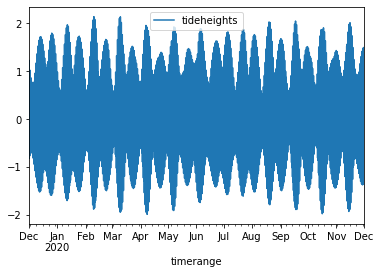

In [7]:
modelledtides.plot(x='timerange', y='tideheights')

## Attempts to use module `uptide`
Also available but untested is module `pytide`. Seems to a forecasting tool and not suited to spring/neap calculation

In [11]:
!pip install uptide

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


In [25]:
# import uptide

## for reference

# time_start = '2019-12-01 00:00:00'
# time_end = '2020-12-01 00:00:00'

# type(time_start)

str

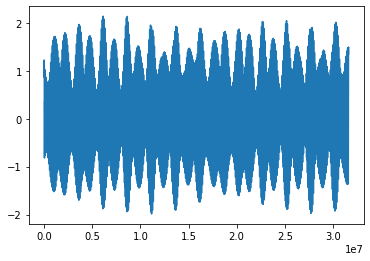

In [36]:
import uptide
import datetime
tide = uptide.Tides(['M2', 'S2'])  # select which constituents to use
tide.set_initial_time(datetime.datetime(2019,12,1,0,0,0))  # set t=0 at 1 Jan 2001, UTC 12:00
amp = [2.0, 1.0]  # amplitudes of M2 and S2
pha = [0., 3.14159]  # phases (in radians!) for M2 and S2

import numpy as np
t = np.arange(0, 366*24*3600+10, 600) # 10 min intervals over 30 days
import matplotlib.pyplot as plt
eta = tide.from_amplitude_phase(amp, pha, t)
plt.plot(t, modelledtides.tideheights)
plt.show()

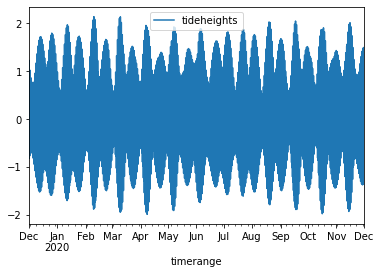

In [37]:
modelledtides.plot(x='timerange', y='tideheights')

In [31]:
amp, pha = uptide.harmonic_analysis(tide, modelledtides.tideheights, t)

In [32]:
amp

array([1.02389182, 0.4132106 ])

In [33]:
pha

array([5.63461548, 5.65723798])

In [34]:
idx = tide.constituents.index('M2')
idx

0

In [35]:
print("M2 amplitude and phase:", amp[idx], pha[idx])

M2 amplitude and phase: 1.0238918151953484 5.634615479797766


In [38]:
uptide.select_constituents

<module 'uptide.tides' from '/env/lib/python3.6/site-packages/uptide/tides.py'>

## Spring/neap detection using `scipy.signal.find_peaks`
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

In [6]:

# t = np.arange(0, 366*24*3600+10, 600) # 10 min intervals over 30 days
# t = np.arange(0,len(modelledtides),1)
modelledtides['count'] = np.arange(0,len(modelledtides),1)
modelledtides.reset_index()

,index,timerange,tideheights,count
0,2019-12-01 00:00:00,2019-12-01 00:00:00,0.871,0
1,2019-12-01 00:10:00,2019-12-01 00:10:00,0.931,1
2,2019-12-01 00:20:00,2019-12-01 00:20:00,0.987,2
3,2019-12-01 00:30:00,2019-12-01 00:30:00,1.037,3
4,2019-12-01 00:40:00,2019-12-01 00:40:00,1.081,4
...,...,...,...,...
52700,2020-11-30 23:20:00,2020-11-30 23:20:00,1.480,52700
52701,2020-11-30 23:30:00,2020-11-30 23:30:00,1.460,52701
52702,2020-11-30 23:40:00,2020-11-30 23:40:00,1.432,52702
52703,2020-11-30 23:50:00,2020-11-30 23:50:00,1.397,52703


In [21]:
modelledtides['count']

2019-12-01 00:00:00        0
2019-12-01 00:10:00        1
2019-12-01 00:20:00        2
2019-12-01 00:30:00        3
2019-12-01 00:40:00        4
                       ...  
2020-11-30 23:20:00    52700
2020-11-30 23:30:00    52701
2020-11-30 23:40:00    52702
2020-11-30 23:50:00    52703
2020-12-01 00:00:00    52704
Freq: 10T, Name: count, Length: 52705, dtype: int64

In [7]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

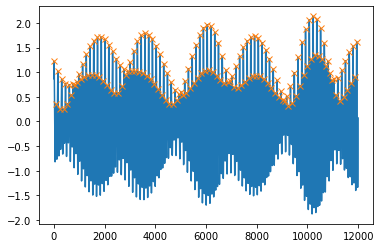

In [15]:
## find all peaks (local maxima) in modelledtides whose amplitude lies above 0
peaks, _ = find_peaks(modelledtides[0:12000].tideheights, height=0)

plt.plot(modelledtides[0:12000]['count'], modelledtides[0:12000].tideheights)
plt.plot(peaks, modelledtides.tideheights[peaks], "x")
# plt.plot(np.zeros_like(modelledtides.tideheights), "--", color='gray')
plt.show()

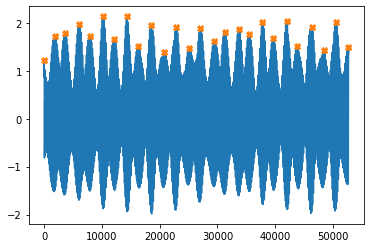

In [118]:
peaks, _ = find_peaks(modelledtides.tideheights, distance=(7.4*24*6), height=1) # in the 10 minute tidal model, a single spring or neap peak should be identified every 7.4 days (distance=8 days*24hrs/day*6timesteps/hr)

plt.plot(modelledtides['count'], modelledtides.tideheights)
plt.plot(peaks, modelledtides.tideheights[peaks], "X")
plt.show()
# plt.plot(modelledtides.tideheights)
# modelledtides.plot(x=t, y=modelledtides.tideheights)

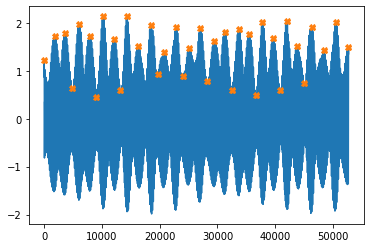

In [150]:
peaks, properties = find_peaks(modelledtides.tideheights, distance=(7.4*24*6), threshold=[0,1]) # in the 10 minute tidal model, a single spring or neap peak should be identified every 7.4 days (distance=8 days*24hrs/day*6timesteps/hr)

# print(len(properties['prominences']))
plt.plot(modelledtides['count'], modelledtides.tideheights)
plt.plot(peaks, modelledtides.tideheights[peaks], "X")
plt.show()
# plt.plot(modelledtides.tideheights)
# modelledtides.plot(x=t, y=modelledtides.tideheights)

In [135]:
# np.diff(peaks)
# peaks
properties

{'peak_heights': array([1.225, 0.646, 0.446, 0.595, 0.932, 0.898, 0.778, 0.591, 0.502,
        0.601, 0.754, 1.495]),
 'prominences': array([0.354, 1.335, 1.062, 1.175, 1.603, 1.688, 1.538, 1.317, 1.101,
        1.143, 1.354, 0.141]),
 'left_bases': array([    0,  4670,  8987, 13155, 19585, 23906, 28075, 32543, 36561,
        40730, 44901, 52513]),
 'right_bases': array([ 1242,  5119,  9138, 13306, 19735, 24055, 28521, 32692, 36711,
        40879, 45359, 52704])}

4.073


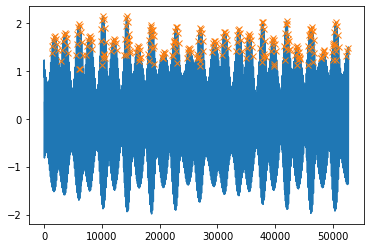

In [84]:
##https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html#scipy.signal.peak_prominences

peaks, properties = find_peaks(modelledtides.tideheights, prominence=(2.5, None))
print(properties['prominences'].max())
plt.plot(modelledtides['count'], modelledtides.tideheights)
plt.plot(peaks, modelledtides.tideheights[peaks], "x")

In [85]:
# properties

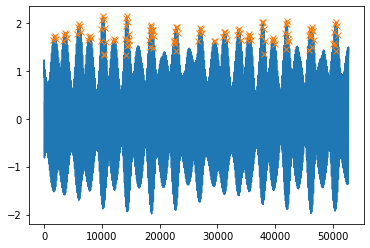

In [112]:
peaks, properties = find_peaks(modelledtides.tideheights, prominence=(3,None), width=15)

plt.plot(modelledtides['count'], modelledtides.tideheights)
plt.plot(peaks, modelledtides.tideheights[peaks], "x")

## Using nearest neighbour analysis to find spring and neap peaks
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelmin.html#scipy.signal.argrelmin

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelmax.html#scipy.signal.argrelmax

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html#scipy.signal.argrelextrema

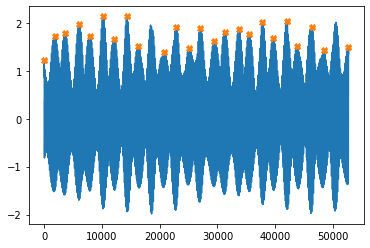

In [191]:
## argrelextrema
from scipy.signal import argrelextrema

maxima = argrelextrema(modelledtides.tideheights.values, np.greater, order=int((7.4*24*6)))
maxima2 = np.array(maxima[0])
plt.plot(modelledtides['count'], modelledtides.tideheights)
plt.plot(maxima2, modelledtides.tideheights[maxima2], "X")

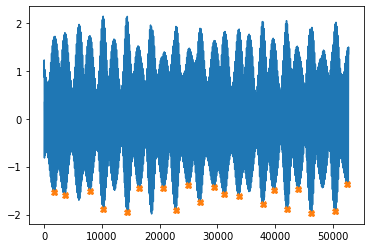

In [192]:
minima = argrelextrema(modelledtides.tideheights.values, np.less, order=int((7.4*24*6)))
minima2 = np.array(minima[0])
plt.plot(modelledtides['count'], modelledtides.tideheights)
plt.plot(minima2, modelledtides.tideheights[minima2], "X")

In [237]:
modelledtides[0:8000].tideheights.values
# modelledtides[0:8000].tideheights.values
# maxspring
# Max2

array([0.871, 0.931, 0.987, ..., 0.598, 0.524, 0.443])

In [238]:
Max2

array([  11,   85,  160,  236,  461,  540,  690,  761,  838,  909,  986,
       1057, 1133, 1205, 1352, 1428, 1500, 1575, 1648, 1723, 1796, 1871,
       1944, 2093, 2168, 2243, 2318, 2393, 2468, 2545, 2619, 2697, 2770,
       2921, 2999, 3071, 3148, 3220, 3296, 3369, 3517, 3592, 3665, 3740,
       3813, 3888, 3961, 4036, 4109, 4184, 4257, 4406, 4480, 4556, 4707,
       4778, 4859, 4929, 5009, 5229, 5307, 5378, 5527, 5602, 5675, 5750,
       5823, 5898, 5971, 6046, 6194, 6268, 6343, 6417, 6492, 6567, 6641,
       6718, 6791, 6870, 6943, 7095, 7174, 7246, 7323, 7396, 7472, 7545,
       7620, 7693, 7768, 7915, 7988])

In [247]:
modelledtides.tideheights[Max2].values

array([1.225, 0.355, 1.02 , 0.253, 0.771, 0.363, 0.541, 0.769, 0.747,
       0.811, 0.962, 0.859, 1.171, 0.903, 0.935, 1.524, 0.949, 1.643,
       0.938, 1.71 , 0.898, 1.718, 0.828, 0.734, 1.563, 0.636, 1.424,
       0.57 , 1.274, 0.585, 1.144, 0.716, 1.061, 1.024, 1.199, 1.017,
       1.441, 1.017, 1.63 , 1.008, 0.981, 1.794, 0.932, 1.766, 0.859,
       1.677, 0.766, 1.539, 0.657, 1.367, 0.542, 0.436, 0.98 , 0.362,
       0.352, 0.646, 0.435, 0.554, 0.605, 0.583, 1.072, 0.672, 0.781,
       1.561, 0.89 , 1.763, 0.98 , 1.905, 1.035, 1.967, 1.935, 1.007,
       1.808, 0.934, 1.596, 0.846, 1.327, 0.782, 1.046, 0.796, 0.816,
       0.694, 1.12 , 0.685, 1.331, 0.739, 1.511, 0.812, 1.64 , 0.877,
       1.713, 1.731, 0.934])

In [249]:
modelledtides.tideheights[maxspring2]#.values
Max2[maxspring]

array([ 160,  461,  761,  986, 1133, 1428, 1575, 1723, 1871, 2168, 2318,
       2468, 2619, 2770, 2999, 3148, 3296, 3592, 3740, 3888, 4036, 4184,
       4480, 4778, 5009, 5307, 5602, 5750, 5898, 6046, 6343, 6492, 6641,
       6791, 6943, 7174, 7323, 7472, 7620, 7915])

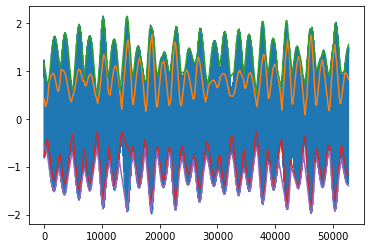

In [127]:
from scipy.signal import argrelmax
from scipy.signal import argrelmin

## Find all spring and neap high tides

## All peaks(maxima) in modelledtides 
Max = argrelmax(modelledtides[0:-1].tideheights.values)
Max = np.array(Max[0])

## Find higher tides in the maxima then the spring high tides 
maxhigh = argrelmax(modelledtides.tideheights[Max].values)
maxhigh = np.array(maxhigh[0])
springhigh = argrelmax(modelledtides.tideheights[Max[maxhigh]].values)
springhigh = np.array(springhigh[0]) 

## Find lower tides in the maxima then the neap high tides
maxlow = argrelmin(modelledtides.tideheights[Max].values)
maxlow = np.array(maxlow[0])
neaphigh = argrelmin(modelledtides.tideheights[Max[maxlow]].values)
neaphigh = np.array(neaphigh[0])

## Repeat to determine spring and neap low tides.

## All minima in modelledtides 
Min = argrelmin(modelledtides[0:-1].tideheights.values)
Min = np.array(Min[0])

## Find higher tides in the maxima then the spring high tides 
minhigh = argrelmin(modelledtides.tideheights[Min].values)
minhigh = np.array(minhigh[0])
springlow = argrelmin(modelledtides.tideheights[Min[minhigh]].values)
springlow = np.array(springlow[0])

## Find lower tides in the maxima then the neap high tides
minlow = argrelmax(modelledtides.tideheights[Min].values)
minlow = np.array(minlow[0])
neaplow = argrelmax(modelledtides.tideheights[Min[minlow]].values)
neaplow = np.array(neaplow[0])

# Add column to modelledtides to plot without using datetime values
modelledtides['count'] = np.arange(0,len(modelledtides),1)

## Interpolate the high and low spring and neap curves
neap_high_linear = interp1d(Max[maxlow], modelledtides.tideheights[Max[maxlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
modelledtides['neap_high_interp'] = neap_high_linear(modelledtides['count'])

spring_high_linear = interp1d(Max[maxhigh], modelledtides.tideheights[Max[maxhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
modelledtides['spring_high_interp'] = spring_high_linear(modelledtides['count'])

neap_low_linear = interp1d(Min[minlow], modelledtides.tideheights[Min[minlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
modelledtides['neap_low_interp'] = neap_low_linear(modelledtides['count'])

spring_low_linear = interp1d(Min[minhigh], modelledtides.tideheights[Min[minhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
modelledtides['spring_low_interp'] = spring_low_linear(modelledtides['count'])

## Extract datetimeindex for each dataslice
spring_high = modelledtides.tideheights[Max[maxhigh[springhigh]]].index
spring_low = modelledtides.tideheights[Min[minhigh[springlow]]].index
neap_high = modelledtides.tideheights[Max[maxlow[neaphigh]]].index
neap_low = modelledtides.tideheights[Min[minlow[neaplow]]].index
hightide = modelledtides[modelledtides.tideheights > modelledtides.neap_high_interp].index
lowtide = modelledtides[modelledtides.tideheights < modelledtides.neap_low_interp].index

## Plot
    # all modelled tides
# plt.plot(modelledtides[0:-1]['count'], modelledtides[0:-1].tideheights) ## all modelled tide heights

    # spring and neap high tides
# plt.plot(Max, modelledtides.tideheights[Max], "X") ## all local maxima (orange)
# plt.plot(Max[maxhigh], modelledtides.tideheights[Max[maxhigh]], "X", color='red') ## higher tides in the maxima dataset (red)
# plt.plot(Max[maxhigh[springhigh]], modelledtides.tideheights[Max[maxhigh[springhigh]]], "o", color='black') ##SPRING HIGH TIDES!! (black)
# plt.plot(Max[maxlow[neaphigh]], modelledtides.tideheights[Max[maxlow[neaphigh]]], "o", color='red') ##NEAP HIGH TIDES!! (red)
    
    ## spring and neap high tides: interpolated
# plt.plot(modelledtides['count'], modelledtides['neap_high_interp'])
# plt.plot(modelledtides['count'], modelledtides['spring_high_interp'])

    # spring and neap low tides
# plt.plot(Min, modelledtides.tideheights[Min], "X") ## all local maxima (orange)
# plt.plot(Min[minhigh], modelledtides.tideheights[Min[minhigh]], "X", color='red') ## higher tides in the maxima dataset (red)
# plt.plot(Min[minhigh[springlow]], modelledtides.tideheights[Min[minhigh[springlow]]], "o", color='black') ##SPRING LOW TIDES!! (black)
# plt.plot(Min[minlow[neaplow]], modelledtides.tideheights[Min[minlow[neaplow]]], "o", color='red') ##NEAP LOW TIDES!! (red)

    ## spring and neap low tides: interpolated
# plt.plot(modelledtides['count'], modelledtides['neap_low_interp'] )
# plt.plot(modelledtides['count'], modelledtides['spring_low_interp'])


In [129]:
# neap_low
# modelledtides
# hightide = modelledtides.tideheights.index.where(modelledtides.tideheights > modelledtides.neap_high_interp)
# hightide
# hightide = modelledtides.where(modelledtides.tideheights > modelledtides.neap_high_interp).plot(x='timerange', y='tideheights')
hightide = modelledtides[modelledtides.tideheights > modelledtides.neap_high_interp].index
lowtide = modelledtides[modelledtides.tideheights < modelledtides.neap_low_interp].index

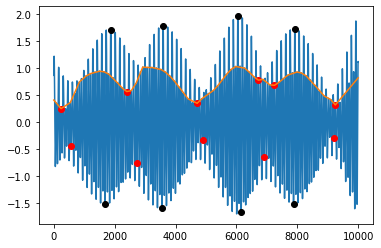

In [106]:
## argrelmax
from scipy.signal import argrelmax
from scipy.signal import argrelmin
from scipy.interpolate import interp1d # for interpolation of new data points

## Find all spring and neap high tides

## All peaks(maxima) in modelledtides 
Max = argrelmax(modelledtides[0:10000].tideheights.values)
Max = np.array(Max[0])

## Find higher tides in the maxima then the spring high tides 
maxhigh = argrelmax(modelledtides.tideheights[Max].values)
maxhigh = np.array(maxhigh[0])
springhigh = argrelmax(modelledtides.tideheights[Max[maxhigh]].values)
springhigh = np.array(springhigh[0]) 

## Find lower tides in the maxima then the neap high tides
maxlow = argrelmin(modelledtides.tideheights[Max].values)
maxlow = np.array(maxlow[0])
neaphigh = argrelmin(modelledtides.tideheights[Max[maxlow]].values)
neaphigh = np.array(neaphigh[0])

## Repeat to determine spring and neap low tides.

## All minima in modelledtides 
Min = argrelmin(modelledtides[0:10000].tideheights.values)
Min = np.array(Min[0])

## Find higher tides in the maxima then the spring high tides 
minhigh = argrelmin(modelledtides.tideheights[Min].values)
minhigh = np.array(minhigh[0])
springlow = argrelmin(modelledtides.tideheights[Min[minhigh]].values)
springlow = np.array(springlow[0])

## Find lower tides in the maxima then the neap high tides
minlow = argrelmax(modelledtides.tideheights[Min].values)
minlow = np.array(minlow[0])
neaplow = argrelmax(modelledtides.tideheights[Min[minlow]].values)
neaplow = np.array(neaplow[0])

# Add column to modelledtides to plot without using datetime values
modelledtides['count'] = np.arange(0,len(modelledtides),1)

## Interpolate the high and low spring and neap curves
neap_high_linear = interp1d(Max[maxlow], modelledtides.tideheights[Max[maxlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
neap_high_interp = neap_high_linear(modelledtides[0:10000]['count'])
spring_high_linear = interp1d(Max[maxhigh], modelledtides.tideheights[Max[maxhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
# spring_high_interp = spring_high_linear(modelledtides[0:10000]['count'])

# neap_low_linear = interp1d(Min[minlow], modelledtides.tideheights[Min[minlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
# neap_low_interp = neap_low_linear(modelledtides[0:10000]['count'])
# spring_low_linear = interp1d(Min[minhigh], modelledtides.tideheights[Min[minhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
# spring_low_interp = spring_low_linear(modelledtides[0:10000]['count'])


## Plot

    ## all modelled tides
plt.plot(modelledtides[0:10000]['count'], modelledtides[0:10000].tideheights) ## all modelled tide heights
    
    ## spring and neap high tides
# plt.plot(Max, modelledtides.tideheights[Max], "X") ## all local maxima (orange)
# plt.plot(Max[maxhigh], modelledtides.tideheights[Max[maxhigh]], "X", color='red') ## higher tides in the maxima dataset (red)
# plt.plot(Max[maxlow], modelledtides.tideheights[Max[maxlow]], "X", color='yellow') ## lower tides in the maxima dataset (yellow)
plt.plot(Max[maxhigh[springhigh]], modelledtides.tideheights[Max[maxhigh[springhigh]]], "o", color='black') ##SPRING HIGH TIDES!! (black)
plt.plot(Max[maxlow[neaphigh]], modelledtides.tideheights[Max[maxlow[neaphigh]]], "o", color='red') ##NEAP HIGH TIDES!! (red)
    
    ## spring and neap high tides: interpolated
plt.plot(modelledtides[0:10000]['count'], neap_high_interp)
# plt.plot(modelledtides[0:10000]['count'], spring_high_interp)

    ## spring and neap low tides
# plt.plot(Min, modelledtides.tideheights[Min], "X") ## all local maxima (orange)
# plt.plot(Min[minhigh], modelledtides.tideheights[Min[minhigh]], "X", color='red') ## higher tides in the maxima dataset (red)
plt.plot(Min[minhigh[springlow]], modelledtides.tideheights[Min[minhigh[springlow]]], "o", color='black') ##SPRING LOW TIDES!! (black)
plt.plot(Min[minlow[neaplow]], modelledtides.tideheights[Min[minlow[neaplow]]], "o", color='red') ##NEAP LOW TIDES!! (red)

#     ## spring and neap low tides: interpolated
# plt.plot(modelledtides[0:10000]['count'], neap_low_interp)
# plt.plot(modelledtides[0:10000]['count'], spring_low_interp)



In [98]:
# len(modelledtides[0:10000])#['count'])
Max = argrelmax(modelledtides[0:-1].tideheights.values)
# Max = np.array(Max[0])

# Max
modelledtides[0:-1].tideheights#.values

2019-12-01 00:00:00    0.871
2019-12-01 00:10:00    0.931
2019-12-01 00:20:00    0.987
2019-12-01 00:30:00    1.037
2019-12-01 00:40:00    1.081
                       ...  
2020-11-30 23:10:00    1.491
2020-11-30 23:20:00    1.480
2020-11-30 23:30:00    1.460
2020-11-30 23:40:00    1.432
2020-11-30 23:50:00    1.397
Freq: 10T, Name: tideheights, Length: 52704, dtype: float64

### (Probably irrelevant) Extracting high and low tide data (all dates between spring and neap high tides - and again for spring/neap low tides)
https://github.com/sigvaldm/localreg

In [80]:
# ## example from https://github.com/sigvaldm/localreg
# !pip install localreg

# import numpy as np
# import matplotlib.pyplot as plt
# from localreg import *

# np.random.seed(1234)
# x = np.linspace(1.5, 5, 2000)
# yf = np.sin(x*x)
# y = yf + 0.5*np.random.randn(*x.shape)

# y0 = localreg(x, y, degree=0, kernel=rbf.tricube, width=0.3)
# y1 = localreg(x, y, degree=1, kernel=rbf.tricube, width=0.3)
# y2 = localreg(x, y, degree=2, kernel=rbf.tricube, width=0.3)

# plt.plot(x, y, '+', markersize=0.6, color='gray')
# plt.plot(x, yf, label='Ground truth ($\sin(x^2)$)')
# plt.plot(x, y0, label='Moving average')
# plt.plot(x, y1, label='Local linear regression')
# plt.plot(x, y2, label='Local quadratic regression')
# plt.legend()
# plt.show()

In [79]:
# # np.random.seed(1234)
# # x = np.linspace(1.5, 5, 2000)


# x = Max[maxlow]
# # yf = np.sin(x*x)
# # y = yf + 0.5*np.random.randn(*x.shape)
# y = modelledtides.tideheights[Max[maxlow]].values

# y0 = localreg(x, y, degree=0, kernel=rbf.tricube, width=0.3)
# y1 = localreg(x, y, degree=1, kernel=rbf.tricube, width=0.3)
# y2 = localreg(x, y, degree=2, kernel=rbf.tricube, width=0.3)

# plt.plot(x, y, 'X')#, markersize=0.6, color='gray')
# # plt.plot(x, yf, label='Ground truth ($\sin(x^2)$)')
# plt.plot(x, y0, 'x', label='Moving average')
# plt.plot(x, y1, 'x', label='Local linear regression')
# plt.plot(x, y2, 'x', label='Local quadratic regression')
# plt.legend()
# plt.show()

## Lowess regression and Scipy interpolation
https://towardsdatascience.com/lowess-regression-in-python-how-to-discover-clear-patterns-in-your-data-f26e523d7a35

Local regression (LOWESS: locally weighted scatterplot smoothing) probably not needed as I have the spring and neap high and low tide arrays already. 
Skip ahead to `interp1d` method from scipy library

In [ ]:
## Goal: identify all modelledtides between neap high and spring high tides.
## Plan: Take the arrays of spring and neap high tides already produced above. 
      ## Interpolate for every x value in the modelled tides array for each curve.
      ## Extract hightide `timerange` by comparing modelledtde value against spring and neap curves.
      ## Repeat for low tide.
    


In [62]:
from scipy.interpolate import interp1d # for interpolation of new data points

neap_high_linear = interp1d(Max[maxlow], modelledtides.tideheights[Max[maxlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
neap_high_interp = neap_high_linear(modelledtides[0:10000]['count'])

spring_high_linear = interp1d(Max[maxhigh], modelledtides.tideheights[Max[maxhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
spring_high_interp = spring_high_linear(modelledtides[0:10000]['count'])

plt.plot(modelledtides[0:10000]['count'], modelledtides[0:10000].tideheights) ## all modelled tide heights
# plt.plot(Max[maxlow], modelledtides.tideheights[Max[maxlow]], "x")#, color='yellow')
plt.plot(modelledtides[0:10000]['count'], neap_high_interp)
plt.plot(modelledtides[0:10000]['count'], spring_high_interp)

In [296]:
modelledtides.tideheights[Min[minlow[neaplow]]].index

DatetimeIndex(['2019-12-04 23:40:00', '2019-12-19 23:30:00',
               '2020-01-03 23:40:00', '2020-01-17 23:10:00',
               '2020-02-03 00:10:00'],
              dtype='datetime64[ns]', freq=None)

In [297]:
## Might need to replace modelledtides with localtides


In [23]:
# ITEMpolygons
gdf_master[255:275]

In [35]:
# gdf_master.set_index('ID', drop=True, inplace=True)
# gdf_master.index['269']

for index, row in gdf_master[255:275].iterrows():
#     if row.ID != 66:
#         next
    if row.ID == 66: ## If a desired ITEM polygon is required, set the value here and enable the `break` at the end of this loop
        
        break
#         continue

        
    

index:  269 row:  66


In [21]:
# ITEMpolygons['269'].day.plot()

#         ## Save exposure results
#         pxpc.drop('time').to_netcdf("ID"
#                        + str(row.ID)
#                        + "_tidepost_"
#                        + str(tp_y) 
#                        + '_'
#                        + str(tp_x) 
#                        + "_pxpc_for_modelledtides20min_" 
#                        + str(time_start)
#                        + '_to_'
#                        + str(time_end)
#                        + "time_filter_"
#                        + str(time_filter)
#                        + ".nc")

ITEMpolygons['269'].day.drop('time').to_netcdf(
                                    'ID'
                                   + str(index)
                                   + "_for_modelledtides30min_" 
                                   + str(time_start)
                                   + '_to_'
                                   + str(time_end)
                                   + "time_filter_day"
#                                    + str(time_filter)
                                   + ".nc")

In [18]:
# ITEMpolygons['269'].night.plot()
row.ID
index

269

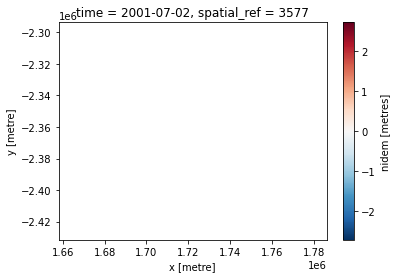

In [10]:
ITEMpolygons['269'].nidem.plot()

In [45]:
## Working day/night code loop

lt_df=pd.DataFrame(localtides, columns=['localtides'])

dates = []
times = []
for element in localtides:
    d = element.date()
    dates.append(d)
    
    t = element.time()
    times.append(t)

lt_df['Date'] = dates
lt_df['Time'] = times

for index,row in sun_df[0:4].iterrows():
    
    ## Translate the time string from sunriset module into datetime.time
    hourday = (int(row['Sunrise hh:mm:ss'].split(':')[0]))
    minuteday = (int(row['Sunrise hh:mm:ss'].split(':')[1]))
    secday = ceil(float(row['Sunrise hh:mm:ss'].split(':')[-1]))
    sunrise = datetime.time(hourday, minuteday, secday)
    
    hournight = (int(row['Sunset hh:mm:ss'].split(':')[0]))
    minutenight = (int(row['Sunset hh:mm:ss'].split(':')[1]))
    secnight = ceil(float(row['Sunset hh:mm:ss'].split(':')[-1]))
    sunset = datetime.time(hournight, minutenight, secnight)
    
    ## Assign day or night by comparison against sunrise and sunset for the day
    conditions = [(lt_df.loc[lt_df['Date'] == index.date()].Time > sunrise) & (lt_df.loc[lt_df['Date'] == index.date()].Time < sunset)]
    choices = ['day']
    lt_df.loc[(lt_df['Date'] == index.date()), ['daynight']] = np.select(conditions, choices, default='night')

    ## Extract day and night arrays to filter localtides against as per other filtering routines
    day_df = lt_df[lt_df.daynight == 'day']
    night_df = lt_df[lt_df.daynight == 'night']
    
    ## Return values to DatetimeIndex
    day = pd.DatetimeIndex(day_df.localtides)
    night = pd.DatetimeIndex(night_df.localtides)



In [53]:
day_df = lt_df[lt_df.daynight == 'day']
night_df = lt_df[lt_df.daynight == 'night']

## Return values to DatetimeIndex
day = pd.DatetimeIndex(day_df.localtides)
night = pd.DatetimeIndex(night_df.localtides)

In [49]:
lt_df.index
# day
night

DatetimeIndex(['2019-12-01 18:40:00+10:00', '2019-12-01 18:50:00+10:00',
               '2019-12-01 19:00:00+10:00', '2019-12-01 19:10:00+10:00',
               '2019-12-01 19:20:00+10:00', '2019-12-01 19:30:00+10:00',
               '2019-12-01 19:40:00+10:00', '2019-12-01 19:50:00+10:00',
               '2019-12-01 20:00:00+10:00', '2019-12-01 20:10:00+10:00',
               ...
               '2020-12-01 08:30:00+10:00', '2020-12-01 08:40:00+10:00',
               '2020-12-01 08:50:00+10:00', '2020-12-01 09:00:00+10:00',
               '2020-12-01 09:10:00+10:00', '2020-12-01 09:20:00+10:00',
               '2020-12-01 09:30:00+10:00', '2020-12-01 09:40:00+10:00',
               '2020-12-01 09:50:00+10:00', '2020-12-01 10:00:00+10:00'],
              dtype='datetime64[ns, Australia/Queensland]', name='localtides', length=52413, freq=None)

In [54]:
len(day)

292

In [55]:
len(night)

224

In [44]:
lt_df[320:380]

,localtides,Date,Time,daynight
320,2019-12-03 15:20:00+10:00,2019-12-03,15:20:00,day
321,2019-12-03 15:30:00+10:00,2019-12-03,15:30:00,day
322,2019-12-03 15:40:00+10:00,2019-12-03,15:40:00,day
323,2019-12-03 15:50:00+10:00,2019-12-03,15:50:00,day
324,2019-12-03 16:00:00+10:00,2019-12-03,16:00:00,day
325,2019-12-03 16:10:00+10:00,2019-12-03,16:10:00,day
326,2019-12-03 16:20:00+10:00,2019-12-03,16:20:00,day
327,2019-12-03 16:30:00+10:00,2019-12-03,16:30:00,day
328,2019-12-03 16:40:00+10:00,2019-12-03,16:40:00,day
329,2019-12-03 16:50:00+10:00,2019-12-03,16:50:00,day


In [ ]:
lt_df

In [ ]:
from math import ceil
import numpy as np
import datetime

for index,row in sun_df[0:1].iterrows():

    hourday = (int(row['Sunrise hh:mm:ss'].split(':')[0]))
    minuteday = (int(row['Sunrise hh:mm:ss'].split(':')[1]))
#     secday = ceil(float(row['Sunrise hh:mm:ss'].split(':')[-1]))
    sunrise = datetime.time(hourday, minuteday)
    
    hournight = (int(row['Sunset hh:mm:ss'].split(':')[0]))
    minutenight = (int(row['Sunset hh:mm:ss'].split(':')[1]))
#     secnight = ceil(float(row['Sunset hh:mm:ss'].split(':')[-1]))
    sunset = datetime.time(hournight, minutenight)
    
    print ('Sunrise: ', sunrise)
    print ('Sunset: ', sunset)

# print(datetime.time(hour,minute,sec))

In [ ]:
sunrise

In [ ]:
# test = lt_df.where(lt_df.Date == index.date()) #& lt_df.where(lt_df.Date == index.date()).Time
# test.where(test.Time >= sunrise & test.Time < sunset
# a = test.Time >= sunrise
# b = test.Time < sunset
lt_df.drop(['daynight'], axis=1)

In [ ]:
# lt_df.where(lt_df.Date == index.date()).Time
lt_df['daynight'] = np.where((lt_df.where(lt_df.Date == index.date()).any().Time > sunrise and lt_df.where(lt_df.Date == index.date()).any().Time < sunset), 'day', 'night')
# lt_df['daynight'] = np.where(sunrise < lt_df.loc[lt_df['Date'] == index.date()].Time.all() < sunset, 'day', 'night')

In [ ]:
lt_df

In [ ]:
# lt_df.daynight
# print( lt_df.Date.values() == index.date())
for r, i in lt_df.loc[lt_df['Date'] == index.date()]:
#     print(r)
# #     lt_df['daynight'] = np.where(sunrise < lt_df.loc[lt_df['Date'] == index.date()].Time.all() < sunset, 'day', 'night')

In [ ]:
daynight.drop(['daynight'], axis=1)
test = lt_df.loc[lt_df['Date'] == index.date()]
print(type(lt_df))
# lt_df['daynight'] = np.where((test.Time.any() < sunset) and (test.Time.any() > sunrise), 'day', 'night')
# test

In [10]:
ltdaynight_df = pd.DataFrame()
# daynight.drop(['daynight'], axis=1)
daynight = lt_df.loc[lt_df['Date'] == index.date()]

conditions = [(daynight['Date'] == index.date()) & (daynight.Time > sunrise) & (daynight.Time < sunset),
              (daynight['Date'] == index.date()) ]
choices = ['day', 'night']

# daynight.loc[:,('daynight')] = np.select(conditions, choices)
lt_df= np.select(conditions, choices)

ltdaynight_df = pd.concat([ltdaynight_df, daynight])
# daynight
ltdaynight_df

/env/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/env/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,localtides,Date,Time,daynight
228,2019-12-03 00:00:00+10:00,2019-12-03,00:00:00,night
229,2019-12-03 00:10:00+10:00,2019-12-03,00:10:00,night
230,2019-12-03 00:20:00+10:00,2019-12-03,00:20:00,night
231,2019-12-03 00:30:00+10:00,2019-12-03,00:30:00,night
232,2019-12-03 00:40:00+10:00,2019-12-03,00:40:00,night
...,...,...,...,...
367,2019-12-03 23:10:00+10:00,2019-12-03,23:10:00,night
368,2019-12-03 23:20:00+10:00,2019-12-03,23:20:00,night
369,2019-12-03 23:30:00+10:00,2019-12-03,23:30:00,night
370,2019-12-03 23:40:00+10:00,2019-12-03,23:40:00,night


In [ ]:
print(sunrise)
print(sunset)

test_df = pd.DataFrame()
test_df = pd.concat([test_df, test])
test_df

In [ ]:
# # type(localtides)#.date()
# for date in localtides:
#     print(type(date.date()))
# sun_df[0:1]
# localtides[0:10]

test = []
for val in localtides[0:1000]:
    if val.date() == pd.to_datetime('2019-12-01').date():
        test.append(val)
#     print(val.date())
print(test[0:10])

In [ ]:
# test = localtides.where(localtides.date() == pd.to_datetime('2019-12-01').date())
localtides.isin([pd.to_datetime('2019-12-01').date()])#==localtides.isin([pd.to_datetime('2019-12-01')])

In [ ]:
# datetime.date('2019-12-01')
pd.to_datetime('2019-12-01')#.date()
localtides[0:2].isin([pd.to_datetime('2019-12-01')])
# test = localtides.where()

In [ ]:
# ## Test cell
# import datetime
# start_date = datetime.date(2019,1,1)
# start_date

In [ ]:
# ## Test cell
# datetime.date(s.year, s.month, s.day)
# # s.year

In [ ]:
# ## Test cell: solar modelling

# ## Prepare data for use in solar modelling function (sunriset)

# ## Translate input dates to datetime
# format = '%Y-%m-%d %H:%M:%S'
# start = pd.to_datetime(time_start, format=format)
# end = pd.to_datetime(time_end, format=format)

# ## Calculate number of days between input dates
# diff = end-start

# ## Return difference in years
# yearsdiff = diff.days/365

# ## Round up to ensure all modelledtide datetimes are captured in solar model
# yearsdiff = int(math.ceil(yearsdiff))

# ## Identify variables for solar model input
# lat = 34.0522 ## from tidepost
# long = -118.2437 ## from tidepost
# local_tz = -8  ## hardcoded for 3 Austral regions

# number_of_years = yearsdiff
# start_date = datetime.date(start.year, start.month, start.day) ## from query

# ## Model sunrise and sunset
# sun_df = sunriset.to_pandas(start_date, lat, long, local_tz, number_of_years)

# ## Return sunrise/sunset in hh:mm:ss format (str)
# sun_df['Sunrise hh:mm:ss'] = sun_df['Sunrise'].apply(
#         lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))
# sun_df['Sunset hh:mm:ss'] = sun_df['Sunset'].apply(
#         lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))

# ## Drop accessory columns
# sun_df = sun_df[['Sunrise hh:mm:ss','Sunset hh:mm:ss']]

# ## Set the index as a datetimeindex to match the modelledtide df
# sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))
 
# # sun_df

In [ ]:
# def tidal_stats(
#                 start=time_start,
#                 end=time_end,
#                 tidepost_lat=None,
#                 tidepost_lon=None,
#                 modelled_freq=modelled_freq,
#                 round_stats=3): 
#     """
#     Takes an xarray.Dataset and statistically compares the tides 
#     modelled for each satellite observation against the full modelled 
#     tidal range. This comparison can be used to evaluate whether the 
#     tides observed by satellites (e.g. Landsat) are biased compared to 
#     the natural tidal range (e.g. fail to observe either the highest or 
#     lowest tides etc).    
       
#     By default, the function models tides for the centroid of the 
#     dataset, but a custom tidal modelling location can be specified 
#     using `tidepost_lat` and `tidepost_lon`.
    
#     Tides are modelled using the OTPS tidal modelling software based on
#     the TPXO8 tidal model: http://volkov.oce.orst.edu/tides/tpxo8_atlas.html
    
#     For more information about the tidal statistics computed by this 
#     function, refer to Figure 8 in Bishop-Taylor et al. 2018:
#     https://www.sciencedirect.com/science/article/pii/S0272771418308783#fig8
    
#     Parameters
#     ----------     
#     ds : xarray.Dataset
#         An xarray.Dataset object with x, y and time dimensions  
#     tidepost_lat, tidepost_lon : float or int, optional
#         Optional coordinates used to model tides. The default is None,
#         which uses the centroid of the dataset as the tide modelling 
#         location.
#     plot : bool, optional
#         An optional boolean indicating whether to plot how satellite-
#         observed tide heights compare against the full tidal range. 
#         Defaults to True.
#     modelled_freq : str, optional
#         An optional string giving the frequency at which to model tides 
#         when computing the full modelled tidal range. Defaults to '2h', 
#         which computes a tide height for every two hours across the
#         temporal extent of `ds`.        
#     round_stats : int, optional
#         The number of decimal places used to round the output statistics.
#         Defaults to 3.
        
#     Returns
#     -------
#     TODO
    
#     """

#     # Generate range of times covering entire period of satellite record
#     all_timerange = pd.date_range(start=start,
#                                   end=end,
#                                   freq=modelled_freq)
#     all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

#     # Use the tidal model to compute tide heights for each observation:  
#     all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
#                       for dt in all_datetimes]
#     all_predictedtides = predict_tide(all_timepoints)   
#     all_tideheights = [predictedtide.tide_m for predictedtide 
#                         in all_predictedtides]

#     return all_timerange, all_tideheights

In [ ]:
# # ##### Build a list of DataArrays to concat

# def exp_model(time_start, time_end, modelledtides, time_filter, tidepost_lat, tidepost_lon):
    
#     '''
#     For each modelled timestep in modelledtides,
#     mask NIDEM for the associated tideheight.
#     Save the lists of timesteps and masked arrays
#     and concatenate to join all arrays on the new
#     dimension 'datetime'
    
#     Time filtering (`time_filter`) options for exposure mapping routine are:
#     all_time,
#     day,
#     night,
#     wet,
#     dry,
#     summer,
#     autumn,
#     winter,
#     spring,
#     Jan,
#     Feb,
#     Mar,
#     Apr,
#     May,
#     Jun,
#     Jul,
#     Aug,
#     Sep,
#     Oct,
#     Nov,
#     Dec
    
#     Use one of the following strings to match your tidepost to set the appropriate `timezone`
#     UTC       =  pytz.UTC ## Coordinated Universal Time
#     UTC + 8   = 'Australia/West'

#     UTC + 9.5 = 'Australia/North'
#                 'Australia/South'

#     UTC + 10  = 'Australia/Queensland'
#                 'Australia/NSW'
#                 'Australia/Victoria'
#                 'Australia/Tasmania'
#     '''
#     ## Automate timezone selection based on location of tidepost
#     ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
#     if tidepost_lon <= 129.0:
#         timezone = 'Australia/West'
#     elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
#         timezone = 'Australia/North'
#     elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
#         timezone = 'Australia/South'
#     elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
#         timezone = 'Australia/Queensland'
#     elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
#         timezone = 'Australia/NSW'
#     else:
#         print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
#     print('Timezone set to', timezone)
    
#     ## Convert time_start and time_end to datetime objects in local timezone
#     time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
#     time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
#     ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
#     localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

#     ## Convert tz-aware index to local timezone
#     localtides = localtides.tz_convert(timezone)
    
#     ## Reset the index of modelledtides to reflect local times
#     modelledtides['local_timerange'] = localtides
#     modelledtides.set_index('local_timerange', inplace=True)
#     modelledtides.drop('timerange', axis=1, inplace=True)
    
#     ## Create a filteredtides dataframe for the filter of interest
#     if time_filter == 'all_time':
#         filteredtides = modelledtides
        
#     elif time_filter == 'night':
#         night = localtides.drop(localtides[(localtides.hour == 6) ## Daylight: arbitrarily between 6 am and 5.59 pm
#                     |(localtides.hour == 7)
#                     |(localtides.hour == 8)
#                     |(localtides.hour == 9)
#                     |(localtides.hour == 10)
#                     |(localtides.hour == 11)
#                     |(localtides.hour == 12)
#                     |(localtides.hour == 13)
#                     |(localtides.hour == 14)
#                     |(localtides.hour == 15)
#                     |(localtides.hour == 16)
#                     |(localtides.hour == 17)
#                     ])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in night.array)
#         filteredtides['timerange'] = night
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'day':
#         day = localtides.drop(localtides[(localtides.hour == 0) ## Nighttime: arbitrarily between 6 pm and 5.59 am
#                     |(localtides.hour == 1)
#                     |(localtides.hour == 2)
#                     |(localtides.hour == 3)
#                     |(localtides.hour == 4)
#                     |(localtides.hour == 5)
#                     |(localtides.hour == 18)
#                     |(localtides.hour == 19)
#                     |(localtides.hour == 20)
#                     |(localtides.hour == 21)
#                     |(localtides.hour == 22)
#                     |(localtides.hour == 23)
#                     ])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in day.array)
#         filteredtides['timerange'] = day
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'dry':
#         dry = localtides.drop(localtides[(localtides.month == 10) ## Wet season: Oct-Mar
#                     |(localtides.month == 11)
#                     |(localtides.month == 12)
#                     |(localtides.month == 1)
#                     |(localtides.month == 2)
#                     |(localtides.month == 3)
#                     ])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in dry.array)
#         filteredtides['timerange'] = dry
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'wet':
#         wet = localtides.drop(localtides[(localtides.month == 4) ## Dry season: Apr-Sep
#                     |(localtides.month == 5)
#                     |(localtides.month == 6)
#                     |(localtides.month == 7)
#                     |(localtides.month == 8)
#                     |(localtides.month == 9)
#                     ])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in wet.array)
#         filteredtides['timerange'] = wet
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)

#     elif time_filter == 'summer':
#         summer = localtides.drop(localtides[localtides.quarter != 1])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in summer.array)
#         filteredtides['timerange'] = summer
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'autumn':
#         autumn = localtides.drop(localtides[localtides.quarter != 2])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in autumn.array)
#         filteredtides['timerange'] = autumn
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'winter':
#         autumn = localtides.drop(localtides[localtides.quarter != 3])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in winter.array)
#         filteredtides['timerange'] = winter
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'spring':
#         spring = localtides.drop(localtides[localtides.quarter != 4])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in spring.array)
#         filteredtides['timerange'] = spring
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Jan':
#         Jan = localtides.drop(localtides[localtides.month != 1])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jan.array)
#         filteredtides['timerange'] = Jan
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
    
#     elif time_filter == 'Feb':
#         Feb = localtides.drop(localtides[localtides.month != 2])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Feb.array)
#         filteredtides['timerange'] = Feb
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Mar':
#         Mar = localtides.drop(localtides[localtides.month != 3])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Mar.array)
#         filteredtides['timerange'] = Mar
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Apr':
#         Apr = localtides.drop(localtides[localtides.month != 4])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Apr.array)
#         filteredtides['timerange'] = Apr
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'May':
#         May = localtides.drop(localtides[localtides.month != 5])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in May.array)
#         filteredtides['timerange'] = May
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Jun':
#         Jun = localtides.drop(localtides[localtides.month != 6])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jun.array)
#         filteredtides['timerange'] = Jun
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Jul':
#         Jul = localtides.drop(localtides[localtides.month != 7])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jul.array)
#         filteredtides['timerange'] = Jul
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Aug':
#         Aug = localtides.drop(localtides[localtides.month != 8])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Aug.array)
#         filteredtides['timerange'] = Aug
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Sep':
#         Sep = localtides.drop(localtides[localtides.month != 9])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Sep.array)
#         filteredtides['timerange'] = Sep
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Oct':
#         Oct = localtides.drop(localtides[localtides.month != 10])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Oct.array)
#         filteredtides['timerange'] = Oct
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Nov':
#         Nov = localtides.drop(localtides[localtides.month != 11])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Nov.array)
#         filteredtides['timerange'] = Nov
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)
        
#     elif time_filter == 'Dec':
#         Dec = localtides.drop(localtides[localtides.month != 12])
        
#         ## Filtering modelledtides by nominated timerange
#         filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Dec.array)
#         filteredtides['timerange'] = Dec
#         filteredtides.set_index('timerange', inplace=True)
#         filteredtides.rename(columns={0:"tideheights"}, inplace=True)

#     else:
#         print('''
#         Please select one of the following `time_filter`s: 
#         all_time, day, night, wet, dry, summer, autumn, winter, 
#         spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
#         ''')
        
        
        
#     ## Boolean mask all modelled timesteps by tideheight relative to NIDEM:
#     da_list = list(ds.nidem >= filteredtides['tideheights'][timestep] 
#                    for timestep in filteredtides.loc[time_start:time_end].index) 
     
#     index_list = list(timestep for timestep in filteredtides[time_start:time_end].index)
    
#     ## Store modelled datetimes as a pandas index
#     index = pd.Index(index_list, name='datetime')

#     ## Concatenate the arrays on the new dimension 'datetime'
#     exp_ds = xr.concat(da_list, index)
    
#     return exp_ds


# # ## TEMP: refresh the modelledtides var
# # modelledtides = pd.read_pickle("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_20min.pkl")

# ## Run function to collect exposure dataset. Set time filter to one of the following:
# '''all_time,
#     day,
#     night,
#     wet,
#     dry,
#     summer,
#     autumn,
#     winter,
#     spring,
#     Jan,
#     Feb,
#     Mar,
#     Apr,
#     May,
#     Jun,
#     Jul,
#     Aug,
#     Sep,
#     Oct,
#     Nov,
#     Dec'''

In [ ]:
# ## Prototyping the continental workflow

# # Loop through polygons in geodataframe and extract satellite data
# for index, row in gdf_master.iterrows():

#     # Extract the feature's geometry as a datacube geometry object
#     geom = geometry.Geometry(geom=row.geometry, crs=gdf_master.crs)

#     # Update the query to include our geopolygon
#     query.update({"geopolygon": geom})

#     ds = dc.load(**query)
#     ds = ds.where(ds.nidem > ds.nidem.min())
    
#     '''-------------------'''
#     ## run tidal model for polygon
#         ## tidepost coords for polygon
#     tp_x = row.lon
#     tp_y = row.lat
    
#     ## Run tidal model function
#     all_timerange, all_tideheights = tidal_stats(tidepost_lat = tp_y,
#                                              tidepost_lon = tp_x)
#     ## Save modelled tides as dataframe
#         ## Firstly convert the dates to series
#     all_timerange = all_timerange.to_series()
#         ## Save dates and tideheights to pd.DataFrame
#     modelledtides = pd.DataFrame(data={'timerange': all_timerange,
#                        'tideheights': all_tideheights})
#     '''-------------------'''
#     ## Run the exp_model function to generate the exposure dataset
#     exp_ds = exp_model(time_start, 
#                        time_end, 
#                        modelledtides, 
#                        time_filter = time_filter, 
#                        tidepost_lat = tp_y, 
#                        tidepost_lon = tp_x) 
    

#     ## Calculate the mean of the boolean across the datetime axis (equiv. to % True)
#     pxpc = exp_ds.mean('datetime')

#     ## Compute the array from dask
#     pxpc = pxpc.compute() #%timeit

#     ## Name the exposure time array
#     pxpc = pxpc.rename('Exposure time (%)')

#     ## Mask out non-intertidal areas
#     pxpc = pxpc.where(pxpc > 0)
    
#     ## Save exposure results
#     pxpc.drop('time').to_netcdf("ID"
#                    + str(row.ID)
#                    + "_tidepost_"
#                    + str(tp_y) 
#                    + '_'
#                    + str(tp_x) 
#                    + "_pxpc_for_modelledtides20min_" 
#                    + str(time_start)
#                    + '_to_'
#                    + str(time_end)
#                    + "time_filter_"
#                    + str(time_filter)
#                    + ".nc")
#     # ## To save the NIDEM dataset to netcdf, need to remove the time dimension
#     ds = ds.squeeze()
#     ds = ds.reset_coords()
#     ds.nidem.to_netcdf("ID" + str(row.ID) +"_tidepost_"+str(tp_y) + '_'+ str(tp_x) +'nidem.nc') 
    
#     ## Stop looping
#     if index == 0:
#         break

In [ ]:
pxpc.plot()

In [ ]:
ds.nidem.plot()

In [ ]:
import matplotlib.pyplot as plt
# pxpc vs ds.nidem
plt.scatter(x=pxpc, y=ds.nidem)

In [ ]:
 ## Save exposure results
pxpc.drop('time').to_netcdf("ID"
               + str(row.ID)
               + "_tidepost_"
               + str(tp_y) 
               + '_'
               + str(tp_x) 
               + "_pxpc_for_modelledtides20min_" 
               + str(time_start)
               + '_to_'
               + str(time_end)
               + "time_filter_"
               + str(time_filter)
               + ".nc")
# ## To save the NIDEM dataset to netcdf, need to remove the time dimension
ds = ds.squeeze()
ds = ds.reset_coords()
ds.nidem.to_netcdf("ID" + str(row.ID) +"_tidepost_"+str(tp_y) + '_'+ str(tp_x) +'nidem.nc') 
   

In [ ]:
https://www.ausmarinescience.com/marine-science-basics/tides/
https://tidesandcurrents.noaa.gov/about_harmonic_constituents.html

In [ ]:
ITEMpolygons#['0']['Jan'].compute()
# for key in ITEMpolygons:
#     for f in ITEMpolygons[key]:
#         print(key, f)

In [ ]:
# (ITEMpolygons['0'])
# ds
ITEMpolygons['1']['Jan'].plot()

In [ ]:
ITEMpolygons['1']['Jan'].plot()